In [1]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))
from pathlib import Path

import pandas as pd
import numpy as np

import scipy
from scipy import optimize, integrate
from scipy import interpolate

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import container
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import time
import math
import random
import multiprocessing as mp

%load_ext autoreload
%autoreload 2

import modules_ns_bim_spherical.geometry as my_oc_geom
import modules_ns_bim_spherical.hybrid_model_oc_v1 as hmoc
import modules_ns_bim_spherical.orthogonal_collocation_v2 as oc
import modules_ns_bim_spherical.oc_plots_v1 as oc_plots


## Resin data

In [2]:
surf_dens_seph = 3.413e-6 # [mol m-2]
surf_dens_caq  = 3.016e-6
surf_dens_phq  = 2.55e-6
surf_dens_pxq  = 3.72e-6

sigma_seph = -1.0 * surf_dens_seph * hmoc.constants().F # [C m-2]
sigma_caq  = surf_dens_caq * hmoc.constants().F
sigma_phq  = surf_dens_phq * hmoc.constants().F
sigma_pxq  = surf_dens_pxq * hmoc.constants().F

print(sigma_seph, sigma_caq, sigma_phq, sigma_pxq)

-0.329303305 0.29099876 0.24603675000000003 0.35892419999999997


In [3]:
def plot_psi_and_residual(fit_1, bc_info):
    seps = np.linspace(0.0, 1, 2000)
    seps = seps.tolist()
    psi = []
    res = []

    for t in seps:
        psi.append(oc.get_psi_at_t(t, fit_1.x, bc_info))
        res.append(oc.scaled_1d_pb_residual(fit_1.x, t, bc_info))

    fig, ax = plt.subplots()
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    fig.set_size_inches(6, 5, forward=True)
    ax2 = ax.twinx()
    ax.set_xlabel('t')
    ax.set_ylabel(r'$\psi$')
    ax2.set_ylabel('PB residual')
    ax.set_xlim(0.0, 1)
    ax.hlines(0, 0, 1)

    v_tick_len = 0.15
    p = len(fit_1.x) - 2
    for i in range(p):
        t_i = 1.0/(2.0*(p)) + i/(p)
        ax.axvline(x=t_i, ymin=0, ymax=0.05, color='k')
    lns1 = ax.plot(seps, psi, '-', label=r'$\psi$, {:.0f} $\delta_i$'.format(p))
    lns2 = ax2.plot(seps, res, '--', color='k', label='Residual')

    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='best', frameon=False, handlelength=1.0)

    oc_plots.align_yaxis(ax, ax2)
    return

def plot_psi_and_residual_cc(fit_1, bc_info):
    seps = np.linspace(0.0, 1, 2000)
    seps = seps.tolist()
    psi = []
    res = []

    for t in seps:
        psi.append(oc.get_psi_at_t_v3(t, fit_1.x, bc_info))
        res.append(oc.scaled_1d_pb_residual_cc(fit_1.x, t, bc_info))

    fig, ax = plt.subplots()
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    fig.set_size_inches(6, 5, forward=True)
    ax2 = ax.twinx()
    ax.set_xlabel('t')
    ax.set_ylabel(r'$\psi$')
    ax2.set_ylabel('PB residual')
    ax.set_xlim(0.0, 1)
    ax.hlines(0, 0, 1)

    v_tick_len = 0.15
    p = len(fit_1.x) - 2
    for i in range(p):
        t_i = 1.0/(2.0*(p)) + i/(p)
        ax.axvline(x=t_i, ymin=0, ymax=0.05, color='k')

    lns1 = ax.plot(seps, psi, '-',label=r'$\psi$, {:.0f} $\delta_i$'.format(p))
    lns2 = ax2.plot(seps, res, '--', color='k', label='Residual')

    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='best', frameon=False, handlelength=1.0)

    oc_plots.align_yaxis(ax, ax2)
    return

-0.45201219248781854 -0.45201219248781854


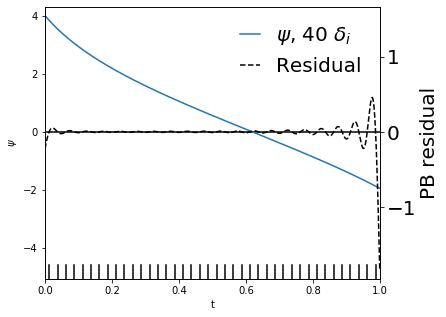

In [4]:
sol       = hmoc.bulk_solution(0.4)
sigma_01  = sigma_caq
phi_02    = -0.05
h         = 1.75/sol.kappa
bc_info   = oc.cp_bc_info(sigma_01=sigma_01, phi_02=phi_02, h=h, bulk_solution=sol)

guess     = np.full(42, 0.0)
guess[-2] = bc_info.c2
guess[-1] = oc.get_c1_initial_guess(bc_info, sol)
fit_1     = oc.get_coeff_vec(guess, bc_info)

bc_info.update_pc_bc_info(fit_1.x)
plot_psi_and_residual(fit_1, bc_info)


# print(vars(bc_info))
print(fit_1.x[-2], bc_info.c2)

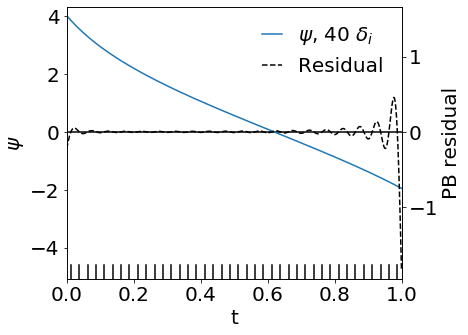

In [5]:
sol       = hmoc.bulk_solution(0.4)
sigma_01  = sigma_caq
sigma_02  = -0.1322075714014998
h         = 1.75/sol.kappa
bc_info   = oc.cc_bc_info(sigma_01=sigma_01, sigma_02=sigma_02, h=h, bulk_solution=sol)

guess     = np.zeros(42)
guess[-1], guess[-2] = oc.get_c1_c2_initial_guess(bc_info, sol)
fit_1                = oc.get_coeff_vec_cc(guess, bc_info)

plot_psi_and_residual_cc(fit_1, bc_info)

### Record individual contributions to the potential of mean force

In [22]:
destination_dir = 'oc_energy_maps_cc/'

ion_str_list    = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
sigma_list      = [sigma_seph, sigma_caq, sigma_phq, sigma_pxq]

seps = np.concatenate((np.linspace(9, 6, 4), np.linspace(5, 2.5, 11), 
                       np.linspace(2, 0.1, 20), np.linspace(0.09, 0.01, 9))) # kap_h
charge_dens = np.concatenate((np.linspace(-2, -0.004, 75), 
                              np.linspace(-0.002, 0.002, 200), 
                              np.linspace(0.004, 2, 75))) # [C m-2]

for j in range(len(ion_str_list)):
    for i in range(len(sigma_list)):
        start_time = time.time()

        sol       = hmoc.bulk_solution(ion_str_list[j])
        sigma_01  = sigma_list[i]
        args_list = [(sigma_01, sigma_02, sol, seps) for sigma_02 in charge_dens]

        pool = mp.Pool(processes = mp.cpu_count())
        results = pool.map(oc.get_energy_for_seps_v3, args_list)
        pool.close()
        pool.join()

        results = [i for res in results for i in res]
        df_t1 = pd.DataFrame(index=seps.tolist(), columns=charge_dens.tolist())
        df_t2 = pd.DataFrame(index=seps.tolist(), columns=charge_dens.tolist())
        df_t3 = pd.DataFrame(index=seps.tolist(), columns=charge_dens.tolist())
        df_t4 = pd.DataFrame(index=seps.tolist(), columns=charge_dens.tolist())
        
        for res in results:
            df_t1.values[df_t1.index.get_loc(res[0]), 
                         df_t1.columns.get_loc(res[1])] = res[2]
            df_t2.values[df_t2.index.get_loc(res[0]), 
                         df_t2.columns.get_loc(res[1])] = res[3]
            df_t3.values[df_t3.index.get_loc(res[0]), 
                         df_t3.columns.get_loc(res[1])] = res[4]
            df_t4.values[df_t4.index.get_loc(res[0]), 
                         df_t4.columns.get_loc(res[1])] = res[5]
        
        u_el  = df_t1.add(df_t2) # All scaled (i.e. dimensionless) energies
        u_el  = u_el.add(df_t3)
        ts    = df_t4
#         f_ch  = -1*df_t2
        total = u_el.add(ts)
#         total = total.add(f_ch)
        
        if sigma_01 == sigma_seph:
            resin = 'sep'
        elif sigma_01 == sigma_caq:
            resin = 'caq'
        elif sigma_01 == sigma_phq:
            resin = 'phq'
        elif sigma_01 == sigma_pxq:
            resin = 'pxq'
        else:
            print('Resin identification issue')

        ion_str_name = str(int(ion_str_list[j]*1.0e3))
        base_name    = destination_dir + resin + '_' + ion_str_name
        u_el_name    = base_name + '_energetic.csv'
        ts_name      = base_name + '_entropic.csv'
#         f_ch_name    = base_name + '_chem_pot.csv'
        total_name   = base_name + '_total_1.csv'
        
        u_el.to_csv(u_el_name)
        ts.to_csv(ts_name)
#         f_ch.to_csv(f_ch_name)
        total.to_csv(total_name)
        
        hmoc.print_time((time.time() - start_time)/60.0)
        print('Completed ' + total_name + '\n')


/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modul

10.04
Completed oc_energy_maps_cc/sep_50_total_1.csv



/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)


10.10
Completed oc_energy_maps_cc/caq_50_total_1.csv



/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)


10.03
Completed oc_energy_maps_cc/phq_50_total_1.csv



/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modul

10.17
Completed oc_energy_maps_cc/pxq_50_total_1.csv



/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)


10.02
Completed oc_energy_maps_cc/sep_100_total_1.csv



/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)


10.03
Completed oc_energy_maps_cc/caq_100_total_1.csv



/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)


9.92
Completed oc_energy_maps_cc/phq_100_total_1.csv



/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)


10.03
Completed oc_energy_maps_cc/pxq_100_total_1.csv



/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)


9.92
Completed oc_energy_maps_cc/sep_200_total_1.csv



/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)


9.96
Completed oc_energy_maps_cc/caq_200_total_1.csv



/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)


9.93
Completed oc_energy_maps_cc/phq_200_total_1.csv



/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)


9.97
Completed oc_energy_maps_cc/pxq_200_total_1.csv



/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)


9.92
Completed oc_energy_maps_cc/sep_300_total_1.csv



/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)


9.84
Completed oc_energy_maps_cc/caq_300_total_1.csv

9.90
Completed oc_energy_maps_cc/phq_300_total_1.csv



/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)


9.90
Completed oc_energy_maps_cc/pxq_300_total_1.csv



/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)
/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)


9.86
Completed oc_energy_maps_cc/sep_400_total_1.csv



/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)


9.92
Completed oc_energy_maps_cc/caq_400_total_1.csv

9.90
Completed oc_energy_maps_cc/phq_400_total_1.csv



/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)


9.90
Completed oc_energy_maps_cc/pxq_400_total_1.csv

9.87
Completed oc_energy_maps_cc/sep_500_total_1.csv

9.84
Completed oc_energy_maps_cc/caq_500_total_1.csv

10.10
Completed oc_energy_maps_cc/phq_500_total_1.csv



/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/orthogonal_collocation_v2.py:143: RuntimeWarning: invalid value encountered in arctanh
  return 4.0*np.arctanh(y)


9.81
Completed oc_energy_maps_cc/pxq_500_total_1.csv



In [6]:
# # Correction of chemical potential contribtution mistake (should be zero for 
# # constant charge boundary conditions)

# destination_dir = 'oc_energy_maps_cc/'
# ion_str_list    = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
# sigma_list      = [sigma_seph, sigma_caq, sigma_phq, sigma_pxq]

# for j in range(len(ion_str_list)):
#     for i in range(len(sigma_list)):
#         sigma_01 = sigma_list[i]
#         ion_str_name = str(int(ion_str_list[j]*1.0e3))

#         if sigma_01 == sigma_seph:
#             resin = 'sep'
#         elif sigma_01 == sigma_caq:
#             resin = 'caq'
#         elif sigma_01 == sigma_phq:
#             resin = 'phq'
#         elif sigma_01 == sigma_pxq:
#             resin = 'pxq'
#         else:
#             print('Resin identification issue')
        
#         total_file = destination_dir + resin + '_' + ion_str_name + '_total_1.csv'
#         f_ch_file  = destination_dir + resin + '_' + ion_str_name + '_chem_pot.csv'
        
#         df_total = pd.read_csv(total_file, index_col=0)
#         df_f_ch  = pd.read_csv(f_ch_file, index_col=0)
        
#         df_total = df_total.subtract(df_f_ch)
#         df_f_ch  = df_f_ch.subtract(df_f_ch)
        
#         df_total.to_csv(total_file)
#         df_f_ch.to_csv(f_ch_file)


0.0


In [43]:
total_file

'oc_energy_maps_cc/pxq_500_total_1.csv'

In [6]:
def plot_df(df, name=None, sep_max=3, sigma_bnds=None):
    for i in df.index:
        if i > sep_max:
            df.drop(labels=i, axis=0, inplace=True)
            
    if sigma_bnds is not None:
        sigma_min = sigma_bnds[0]
        sigma_max = sigma_bnds[1]
        for i in df.columns:
            i_val = float(i)
            if i_val < sigma_min or i_val > sigma_max:
                df.drop(labels=i, axis=1, inplace=True)
    
    x = []
    y = []
    for col in df.columns:
        y.append(float(col))
    for row in df.index:
        x.append(row)

    X, Y = np.meshgrid(x, y)
    X = X.transpose()
    Y = Y.transpose()

    Z = np.zeros((len(x), len(y)))
    for row in range(len(x)):
        for col in range(len(y)):
            Z[row, col] = df.values[row, col]

    fig = plt.figure()
    fig.set_size_inches(12, 9, forward=True)
    ax = fig.add_subplot(111, projection='3d')
    font = {'weight': 'normal', 'size': 20}
    plt.rc('font', **font)
    # surf = ax.plot_wireframe(X, Y, Z)
    surf = ax.plot_surface(X, Y, Z, cmap=cm.plasma)
    fig.colorbar(surf, shrink=0.5) # shrink=0.5, aspect=5

    pad = 15
    ax.set_xlabel(r'Separation [$\kappa$H]', labelpad=pad)
    ax.set_ylabel(r'Charge density [C/m$^2$]', labelpad=pad)
    ax.set_zlabel('ND energy [-]', labelpad=pad)

    tick_size = 14
    ax.tick_params(labelsize=tick_size)
    ax.view_init(20, 220)
    ax.dist = 10.5
    
    if name is not None:
        fig.savefig(name, bbox_inches='tight', dpi=300)

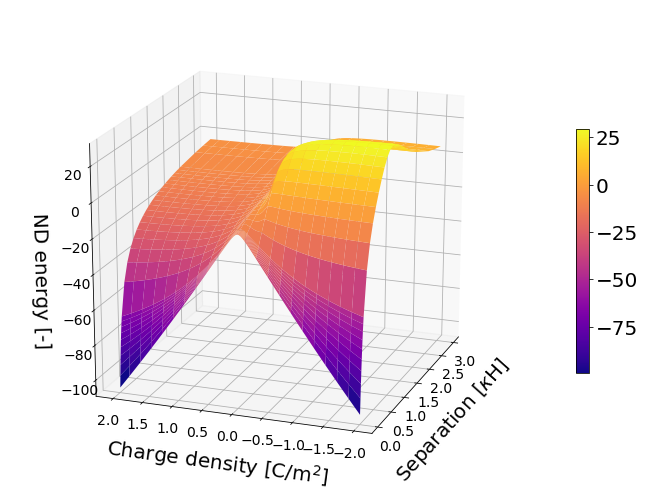

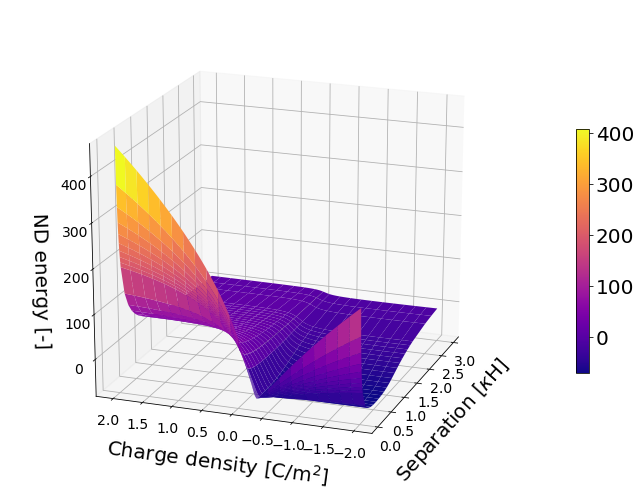

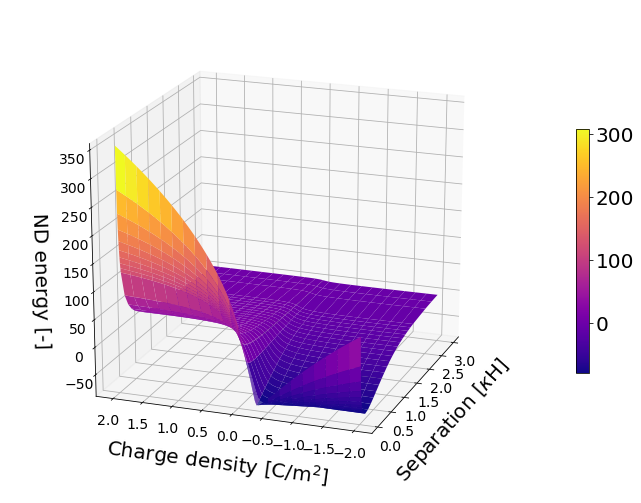

In [41]:
destination_dir = 'oc_energy_maps_cc/'
combo           = 'caq_400'
base_name       = destination_dir + combo
image_destinat  = destination_dir + 'images/'

u_el_name    = base_name + '_energetic.csv'
ts_name      = base_name + '_entropic.csv'
total_name   = base_name + '_total_1.csv'

df_files = [u_el_name, ts_name, total_name]

for ind, df_file in enumerate(df_files):
    if ind == 0:
        name = 'energetic'
    elif ind == 1:
        name = 'entropic'
    elif ind == 2:
        name = 'total_1'
    image_file = image_destinat + combo + '_' + name + '.png'
    
    df = pd.read_csv(df_file, index_col=0)
    plot_df(df, image_file)

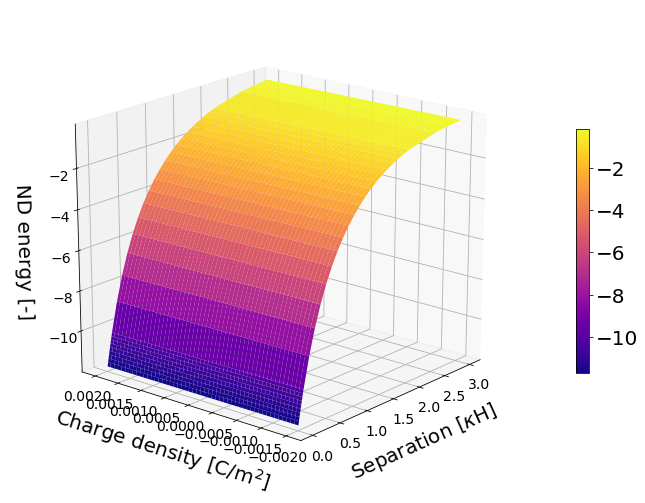

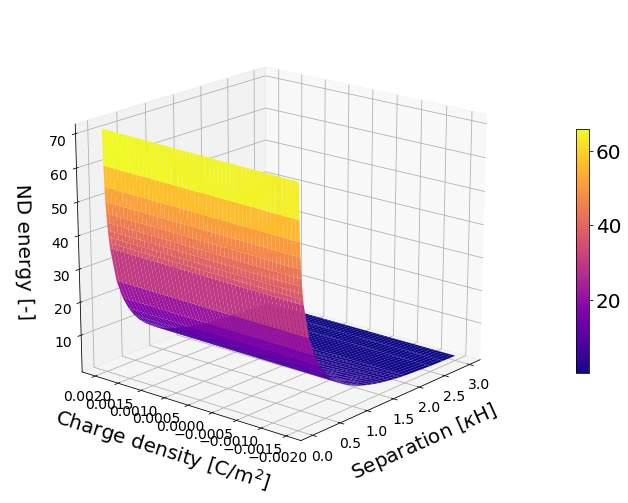

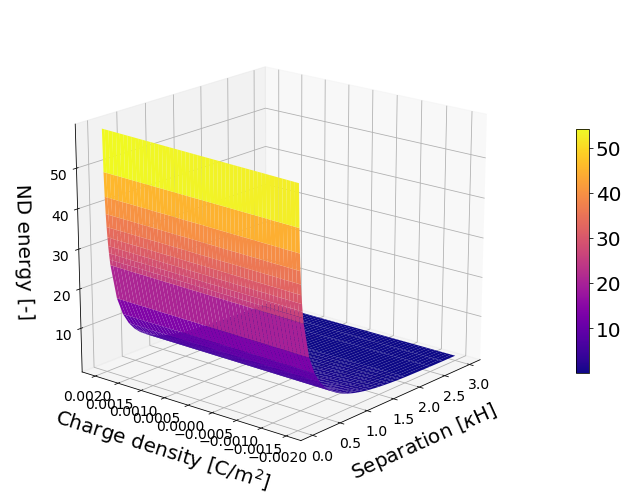

In [7]:
destination_dir = 'oc_energy_maps_cc/'
combo           = 'caq_400'
base_name       = destination_dir + combo
image_destinat  = destination_dir + 'images/'

u_el_name    = base_name + '_energetic.csv'
ts_name      = base_name + '_entropic.csv'
total_name   = base_name + '_total_1.csv'

df_files = [u_el_name, ts_name, total_name]

for ind, df_file in enumerate(df_files):
    if ind == 0:
        name = 'energetic'
    elif ind == 1:
        name = 'entropic'
    elif ind == 2:
        name = 'total_1'
    image_file = image_destinat + 'Super_zoomed_' + combo + '_' + name + '.png'
    
    df = pd.read_csv(df_file, index_col=0)
#     plot_df(df, image_file, sigma_bnds=(-0.5, 0.5))
    plot_df(df, image_file, sigma_bnds=(-0.002, 0.002))